In [11]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib
from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

In [12]:
import yfinance as yf
import pandas as pd

# Step 1: Fetch Historical Stock Data
# Download historical data
adobe = yf.download("ADBE", start="2010-01-01", end="2018-01-01")
microsoft = yf.download("MSFT", start="2010-01-01", end="2018-01-01")

# Combine data using merge
data = pd.merge(adobe['Close'], microsoft['Close'], left_index=True, right_index=True, suffixes=('_adobe', '_microsoft'))

# Rename columns for clarity
data.columns = ['adobe_close', 'microsoft_close']

# Check the combined data
print(data.head())

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

            adobe_close  microsoft_close
Date                                    
2010-01-04    37.090000        23.347324
2010-01-05    37.700001        23.354866
2010-01-06    37.619999        23.211540
2010-01-07    36.889999        22.970140
2010-01-08    36.689999        23.128551


In [40]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

#--------------------------------------------------------------------------------------

def adf_test(x, y):
    df = pd.DataFrame({'y':y,'x':x})
    est = sm.OLS(df.y, df.x)
    est = est.fit()
    df['hr'] = -est.params[0]
    df['spread'] = df.y + (df.x * df.hr)

    return adf[1]

#--------------------------------------------------------------------------------------

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

#--------------------------------------------------------------------------------------

def KalmanFilterAverage(x):
    # Construct a Kalman filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

#--------------------------------------------------------------------------------------

#  Kalman filter regression
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

def KalmanFilterRegression(x, y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)  # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(
        n_dim_obs=1, n_dim_state=2,  # y is 1-dimensional, (alpha, beta) is 2-dimensional
        initial_state_mean=[0, 0],
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=2,
        transition_covariance=trans_cov,
    )

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)

    # Plot the results
    alphas = state_means[:, 0]  # Slope (alpha)
    betas = state_means[:, 1]   # Intercept (beta)

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color="blue", label="Data Points", alpha=0.7)

    # Plot evolving regression lines
    for i in range(0, len(alphas), max(1, len(alphas) // 20)):  # Reduce line frequency for clarity
        y_pred = alphas[i] * x + betas[i]
        plt.plot(x, y_pred, color="red", alpha=0.3, label=f"Step {i}" if i == 0 else "")

    # Final regression line
    y_final = alphas[-1] * x + betas[-1]
    plt.plot(x, y_final, color="green", linewidth=2, label="Final Regression Line")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title("Kalman Filter Regression: Evolving State Means")
    plt.show()

    return state_means

def backtest(s1, s2, x, y ):

    # INPUT:
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two

    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: sharpe ratio

    # Run regression to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))

    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)

    ##############################################################

    halflife = half_life(df1['spread'])

    ##########################################################

    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()


    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    ##############################################################

    entryZscore = 1.7
    exitZscore = 0

    # Set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short
    df1['short entry'] = ((df1.zScore >  entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    # df1.to_csv('results2.csv')

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    #############################################################
    return df1['cum rets'], sharpe

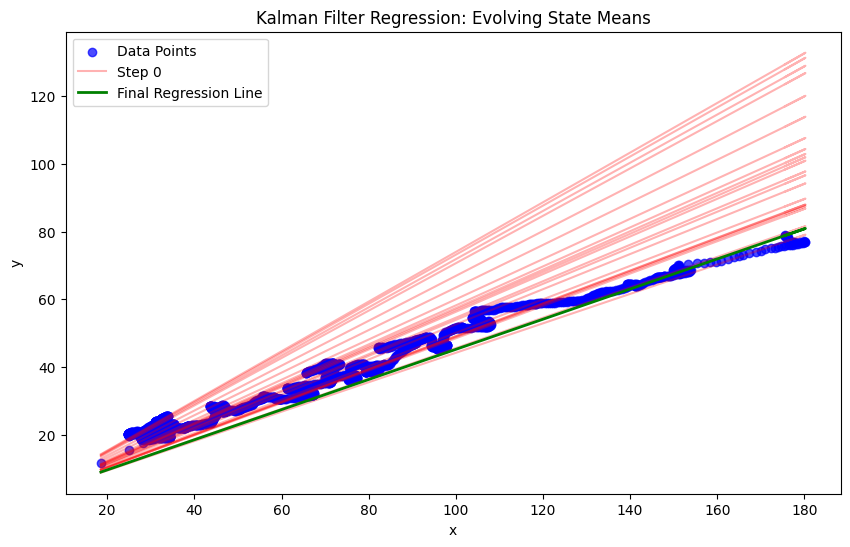

Cumulative Returns:
 Date
2010-01-04         NaN
2010-01-05    1.000000
2010-01-06    1.000000
2010-01-07    1.000000
2010-01-08    1.000000
                ...   
2017-12-22    1.675413
2017-12-26    1.675413
2017-12-27    1.675413
2017-12-28    1.675413
2017-12-29    1.675413
Name: cum rets, Length: 2013, dtype: float64
Sharpe Ratio: 1.2590085986090875


In [41]:
# Call the backtest function
results = backtest(
    s1="ADBE",
    s2="MSFT",
    x=data['adobe_close'],
    y=data['microsoft_close']
)

# Extract the results
df_cum_rets, sharpe = results  
print("Cumulative Returns:\n", df_cum_rets)
print("Sharpe Ratio:", sharpe)


In [42]:
ret = pd.DataFrame()

In [43]:
ret['ADBE-MSFT'] = df_cum_rets.values

In [44]:
ret.tail(3)

,ADBE-MSFT
2010,1.675413
2011,1.675413
2012,1.675413


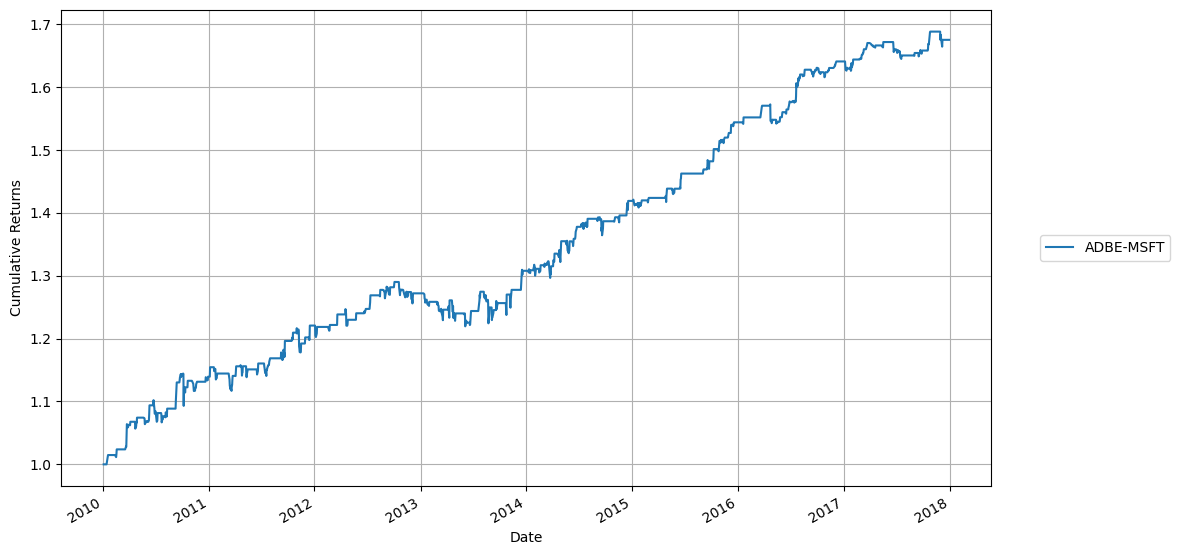

In [45]:
# Show the results of in-sample testing
ret.iloc[0] = 1
ret.index = data.index
ret.plot(figsize=(12,7),grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Cumulative Returns')
plt.show()

In [46]:
# Calculate the performance
perf = ret.calc_stats()
perf.display()

Stat                 ADBE-MSFT
-------------------  -----------
Start                2010-01-04
End                  2017-12-29
Risk-free rate       0.00%

Total Return         67.54%
Daily Sharpe         1.23
Daily Sortino        1.97
CAGR                 6.68%
Max Drawdown         -5.49%
Calmar Ratio         1.22

MTD                  -0.47%
3m                   1.03%
6m                   0.92%
YTD                  2.10%
1Y                   2.10%
3Y (ann.)            5.69%
5Y (ann.)            5.67%
10Y (ann.)           -
Since Incep. (ann.)  6.68%

Daily Sharpe         1.23
Daily Sortino        1.97
Daily Mean (ann.)    6.61%
Daily Vol (ann.)     5.38%
Daily Skew           -0.13
Daily Kurt           29.08
Best Day             2.73%
Worst Day            -4.42%

Monthly Sharpe       1.68
Monthly Sortino      4.95
Monthly Mean (ann.)  6.42%
Monthly Vol (ann.)   3.81%
Monthly Skew         0.88
Monthly Kurt         2.38
Best Month           5.01%
Worst Month          -1.96%

Yearly Shar

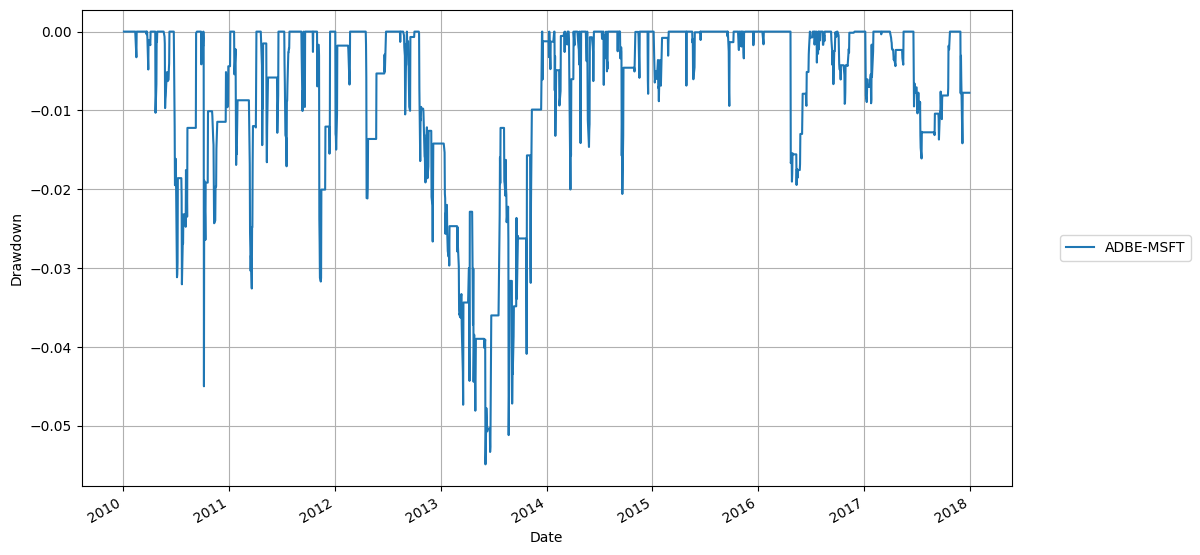

In [47]:
# Plot the maximum drawndown of each pair
ffn.to_drawdown_series(ret).plot(figsize=(12,7),grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Drawdown')
plt.show()

start                    2010-01-04 00:00:00
end                      2017-12-29 00:00:00
rf                                       0.0
total_return                        0.675413
cagr                                0.066775
max_drawdown                       -0.054865
calmar                              1.217076
mtd                                -0.004717
three_month                         0.010286
six_month                           0.009238
ytd                                 0.020954
one_year                            0.020954
three_year                          0.056883
five_year                             0.0567
ten_year                                 NaN
incep                               0.066775
daily_sharpe                        1.228141
daily_sortino                       1.966742
daily_mean                          0.066092
daily_vol                           0.053814
daily_skew                         -0.132196
daily_kurt                         29.082596
best_day  

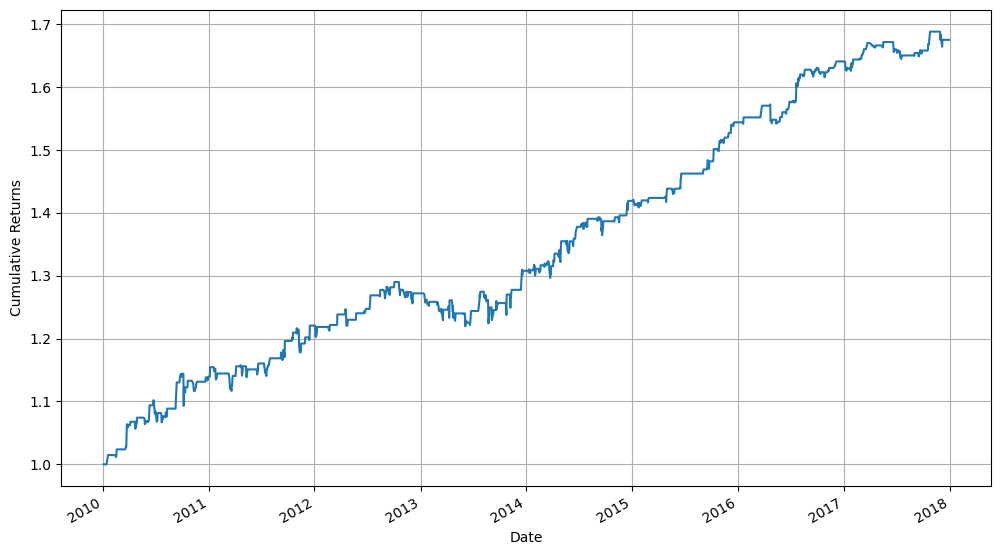

In [48]:
# In sample back testing of portfolio
port = ret.mean(axis=1)
port.plot(figsize=(12,7),grid=True)
perf = port.calc_stats()
plt.ylabel('Cumulative Returns')
perf.stats

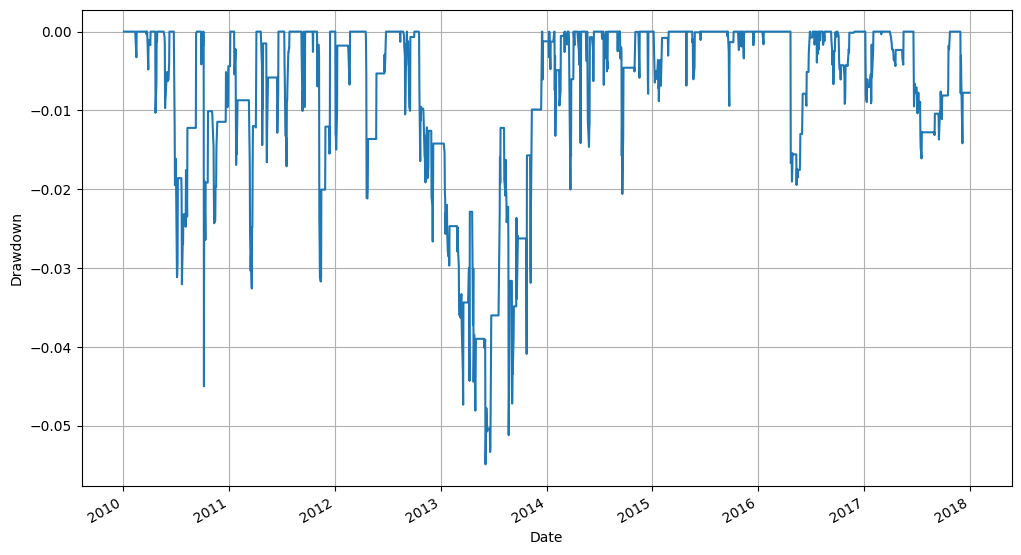

In [49]:
# In sample back testing of portfolio maximum drawdown
ffn.to_drawdown_series(port).plot(figsize=(12,7),grid=True)
plt.ylabel('Drawdown')
plt.show()